In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

In [35]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [36]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


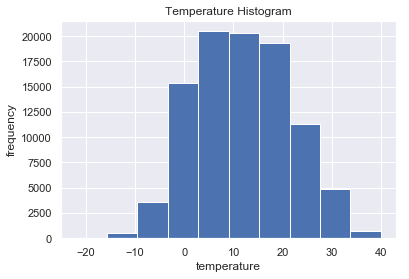

In [37]:
#examine target variable

plt.hist(weather_df.temperature)
plt.title("Temperature Histogram")
plt.xlabel("temperature")
plt.ylabel("frequency")
plt.show()

## Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [38]:
lrm = linear_model.LinearRegression()

X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]
Y = weather_df.temperature



lrm.fit(X, Y)
predictions = lrm.predict(X)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.926438185286


## Check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

## Assumption one: linearity of the model in its coefficients

We have used a model that ensures this condition is met.

## Assumption two: the error term should be zero on average

We have included a constant term in our model to meet this condition.

## Assumption three: homoscedasticity

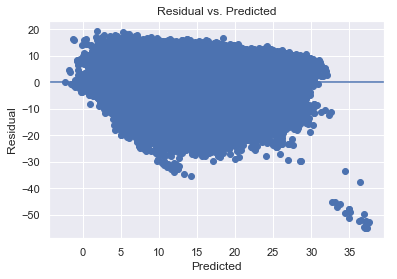

In [39]:
errors = Y - predictions

plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [34]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


 The test results reject the null hypothesis; the errors are heteroscedastic. The module doesn't really discuss the implications of heteroscedasticity beyond saying that it "may make some estimated coefficients seem to be statistically insignificant."

## Assumption four: low multicollinearity

In [40]:
X.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


Our features are only weakly correlated, so this assumption is met by the model.

## Assumption five: error terms should be uncorrelated with one another

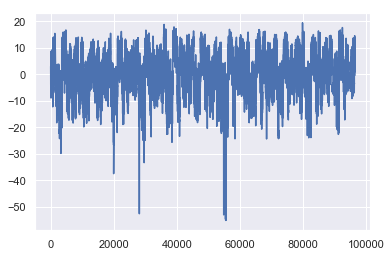

In [41]:
plt.plot(errors)
plt.show()

The errors seem to be uncorrelated; the model meets this assumption.

## Assumption six: features shouldn't be correlated with the errors

In [43]:
X['errors'] = errors
X.corr()

,humidity,windspeed,windbearing,pressure,errors
humidity,1.000000e+00,-2.249515e-01,7.346454e-04,5.454263e-03,2.359581e-14
windspeed,-2.249515e-01,1.000000e+00,1.038215e-01,-4.926281e-02,-5.504464e-15
windbearing,7.346454e-04,1.038215e-01,1.000000e+00,-1.165088e-02,-1.427692e-16
pressure,5.454263e-03,-4.926281e-02,-1.165088e-02,1.000000e+00,-1.025022e-15
errors,2.359581e-14,-5.504464e-15,-1.427692e-16,-1.025022e-15,1.000000e+00


The errors are uncorrelated with the features!  The model meets assumption six.  Also of note: the errors have a near normal distribution, as shown in the following histogram:

Text(0.5, 1.0, 'Histogram of the errors')

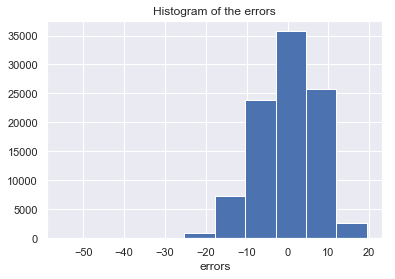

In [45]:
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

## Conclusion: 

The model met five of the six Gauss-Markov Conditions. The assumption of homoscedasticity or the errors was not met by this model.